<a href="https://colab.research.google.com/github/ivyclare/PrivateAI/blob/master/COVID_PATE_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting an Invisible Enemy With Invisible Data

Imagine you work as a DL researcher in a hospital and your job is to find ways to assist doctors in their fight against diseases. Due to the coronavirus(the invisible enemy) pandemic, there is a growing number patients and  a pool of CT images waiting to be diagnosed. You decide to create an image classifier which would not only reduce the burden on clinicians and help them make more informed decisions, it would also lead to faster diagnosis and potentially save lives. However, there is a challenge; **your CT Images are not labelled**. 

It comes to your attention that 5 other hospitals have annotated (positive or negative for COVID 19) CT scans which is exactly what you need. Even though these hospitals are willing to help, they have privacy concerns about sharing the information of their patients and so cannot give out the data. How can you make use of these datasets without accessing them directly? How can you assure these hospitals that the patients data will be protected? Is it even a possibility?. Is it even a possibility?. We try to answer these questions in this blog post.

Spoiler alert! Yes, it is possible :). 

We are not only going to learn how this is possible, we are also going to do a hands on implementation on a COVID-19 dataset. 

The solution to our problem lies in a privacy preserving method called differential privacy. We will focus on PATE Analysis, specifically. Don't get worried if you are not familiar with these terms as we will introduce these concepts.



Let me introduce you to Alice. Alice works as a DL researcher in a hospital and her job is to find ways to assist doctors in their fight against diseases. Due to the coronavirus(the invisible enemy) pandemic, there is a growing number patients and  a pool of CT images waiting to be diagnosed. She decides to create an image classifier which would not only reduce the burden on clinicians and help them make more informed decisions, it would also lead to faster diagnosis and potentially save lives. However, there is a challenge; **her CT Images are not labelled**. 

It comes to her attention that 5 other hospitals have annotated (positive or negative for COVID 19) CT scans which is exactly what she needs. Even though these hospitals are willing to help, they have privacy concerns about sharing information of their patients and so cannot give out the data. How can Alice make use of these datasets without accessing them directly? How can she assure these hospitals that the patients data will be protected? Is it even a possibility?. We try to answer these questions in this blog post and help Alice solve her problem.

Spoiler alert! Yes, it is possible :). 

We are not only going to learn how this is possible, we are also going to do a hands on implementation on a COVID-19 dataset. 




### Problem
Preserve privacy of training data (data from partner hospitals) when building a deep learning model. 



### Solution

The solution to our problem lies in a privacy preserving method called differential privacy. We will focus on PATE Analysis, specifically. Don't get worried if you are not familiar with these terms as we will introduce these concepts first. 

So, what is differential privacy?. 
Differential privacy is a notion of privacy that was introduced by Cynthia Dwork et al.[1](https://link.springer.com/chapter/10.1007/11681878_14) which ensures that statistical analysis does not compromise privacy. 
It makes sure that the effect that an individual's data has on the overall model output is limited. In other words, the output of an algorithm is pretty much the same, with or without the data of a specific individual in the dataset.

## ADD IMAGE HERE

As can be seen in the image above, John's information is present in the first dataset and absent in the second but the model output is the same. The intuition here is that, an adversary who wants to get John's data can't determine whether or not John is present in the dataset - let alone the contents of his data. Hence, John's privacy is guaranteed. 

Differential privacy typically works by adding statistical noise either at the input level (local differential privacy) or the output level (global differential privacy) of the model or statistiscal query. The addition of noise guarantees that individual user contributions are concealed but at the same time we gain insights into the overall population without sacrificing privacy. The amount of noise added is dependent on a parameter called the privacy budget which is often denoted by epsilon (ε). The smaller the value of epsilon is (i.e more noise added), the higher the privacy it provides and vice versa. As shown in the image below, we can see that as more noise is added the face, the more anonymous it gets and the less useful it becomes. Hence, choosing the right epsilon value is very important.

 ### IMAGE HERE - TRADEOFF
[Source](https://aircloak.com/explaining-differential-privacy/)


The differential privacy method we are going to use is called PATE (**Private Aggretion of Teacher Ensembles**) which was proposed by Papernot et al. [(3)](https://arxiv.org/pdf/1610.05755.pdf). The PATE framework is similar to any other supervised machine learning approach but the resulting model here guarantees privacy. The following paragraph gives some insight into how the PATE framework works:

First, several models are gotten from training disjoint datasets i.e datasets that have no training examples in common. These models are called teacher models. An input is then sent into all these teacher models and they each produce an output, typically a class label. The final class of the input image is the aggregate of the output of all teacher models.
If all/most models agreed on a particular class, then it is easy to conclude the class of the input. 
This means that no private information is leaked about any single training example because if any training example is removed from one of the datasets, the models will still agree on the same output. In this case, the privacy budget is low and the algorithm satisfies differential privacy. 

On the otherhand, if the models disagree (high privacy budget), this can lead to confusion about what class the input image belongsto and can eventually lead to privacy leakage. In order to solve this problem, we apply the Report Noisy Max(RNM) algorithm, which adds random noise to the output of the each model. This method provides a meaningful and strong privacy guarantee. At this juncture, the algorithm is completely differentially private. 

The beauty about PATE analysis is that it does not just end here, it goes an extra mile to increase privacy. There are 2 main reasons why we cannot use the aggregate teacher models for inference:
1. Every time we make a prediction, the privacy budget increases. Therefore, we will eventually reach a point where privacy leaks will be inevitable. 
2. Through multiple querying or model inspection, an adversary can access the training data of the teachers which will be disastrous. 

For these reasons, creating a student model becomes a necessity. The student model is a public unlabeled dataset that can now be labeled with the teacher models. Once the student is labeled, the teacher models can be discarded and inference is done only on the student model. Now, the only available model is the student model which has already learned generalizations from the aggregated teachers. When using the student model for inference, the privacy budget does not increase with every query and in the worse case, an adversary can only get the noisy labels that were provided by the teachers with differential privacy.

### INSERT IMAGE HERE

### Creating A Differentially Private Classifier for COVID-19

Let's remind ourselves of the goal. The objective is to train a classifier for your hospital, that can tell if a patient has COVID-19 or not. You have an unlabelled dataset of CT Scan images for patients that may or may not have the virus. Now, you need data from 5 other hospitals to label your dataset and for privacy reasons you can't have access to the data directly. After hearing about differential privacy and the PATE framework, you decide to give it a go. These are the steps you'll follow:

1. You'll ask each of the 5 hospitals to train a model on their own datasets. The generated models are the teacher models.
2. You'll then use each of 5 teacher models to generate 5 labels for each of our CT Images.
3. To ensure the privacy of teacher training datasets, you apply the Report Noisy Max (RNM) algorithm on the generated labels. For each CT Scan, you get the most frequent label across the 5 generated labels, then add noise to make this differentially private.
4. You now use the noisy labels to train your model(student model) which you will be deployed in your hospital. 

Time to roll our sleeves and begin the fun part. Coding!



### Step 1:  Install PySyft

First, we have set up our environment and import the libraries we will be using. I am assuming you are using Google Colab as it already has most of the dependencies we need and the only library we'll have to install is PySyft.  
PySyft is an open-source framework created by OpenMinded that enables secured, private computations in deep learning. Pysyft will enable us perform PATE analysis. In Colab, run the cell below to 

Run the code below to install pysyft and import libraries

In [0]:
# ## install syft package to use Private Aggregation of Teacher Ensembles (PATE)
!pip install syft

In [0]:
# import our libraries
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms,models
from torch.utils.data import Dataset, Subset, DataLoader
from torch import nn, optim
import torch.nn.functional as F
from PIL import Image
import time, os, random


# libary from pysyft needed to perform pate analysis
from syft.frameworks.torch.dp import pate

# we'll trian on GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



Our dataset will be uploaded to google drive, hence we have to get authorized access. After getting access, we navigate to our project directory using `cd`


In [3]:
## authorize access to google drive
from google.colab import drive
drive.mount('/content/drive')

# navigate to project directory
%cd '/content/drive/My Drive/Colab Notebooks/OpenMined/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/OpenMined


Currently, there are not many open-source datasets and models for COVID-19 diagnostic purposes. It is also understandable why getting access to such datasets is challenging mainly for patient privacy and legal reasons. This adds more emphasis on why privacy preserving methods are very important.
Because of the rarity of the COVID-19 data, we will be using one dataset, which you can download [here](https://github.com/UCSD-AI4H/COVID-CT). 
The dataset can be found in **Images_Processed** folder. It divided into COVID and Non-COVID images. The labels for the images can be found in the **Data_Split** folder. Now, we have to organize the project. Create a **data** directory on your google drive and upload these 2 folders into this directory. Now, rename the **Images_Processed** folder to **images** and the **Data_Split** folder to **labels**.  At the end, your data directory, should look like the this:

### INSERT IMAGE HERE - fileStructure.png



### Step 2: Create Teacher and Student Datasets

In order to train the model in a differentially private manner, we need 2 main components; private datasets (teachers) and public unlabelled dataset (student).Looking at the labels directory, you'll notice that the labels have been split into train, validation and test sets. Hence, we'll have to create the teacher and student datasets ourselves. 

We will use the train set as training dataset for the teachers, the test dataset will be used as the student's training dataset and the validation set will be used to test the performance of the student model and normal model (model that has been trained without differential privacy). This can summarized in the table below:

### INSERT TABLE IMAGE HERE

\begin{array}{ccc}
\text{Dataset}&\text{Used As}\\
{Train Dataset}& {Teacher Training Datasets}\\
Test Dataset& Student Dataset\\
Validation Dataset& Testing Model Performance
\end{array}

Time to load the train, validation and test datasets.  



In [0]:
# Custom dataset
class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        label = int(self.img_list[idx][1])
        return image, label



def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data


In [15]:
batchsize=16
path = './data/images'

# Transforms used for datasets
data_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# divided among teachers
trainset = CovidCTDataset(root_dir=f'{path}', 
                              txt_COVID='./data/labels/COVID/trainCT_COVID.txt',
                              txt_NonCOVID='./data/labels/NonCOVID/trainCT_NonCOVID.txt',
                              transform= data_transforms)
 
# used as student valid set    
validset = CovidCTDataset(root_dir=f'{path}',
                              txt_COVID='./data/labels/COVID/valCT_COVID.txt',
                              txt_NonCOVID='./data/labels/NonCOVID/valCT_NonCOVID.txt',
                              transform= data_transforms)

# used as student train set    
testset = CovidCTDataset(root_dir=f'{path}',
                              txt_COVID='./data/labels/COVID/testCT_COVID.txt',
                              txt_NonCOVID='./data/labels/NonCOVID/testCT_NonCOVID.txt',
                              transform= data_transforms)

print("Number of Classes: ",len(trainset.classes))
len(trainset), len(testset), len(validset)

Number of Classes:  2


(425, 203, 118)

We have successfully loaded our data, now let's visualize the data and labels.

 Image Size torch.Size([16, 3, 224, 224])
 Image Size torch.Size([3, 224, 224])


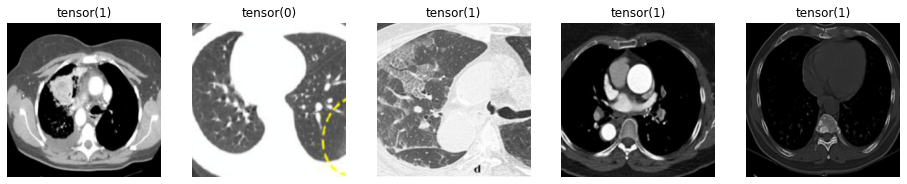

In [10]:
data_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True)

import matplotlib.pyplot as plt

## Method to display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    #print(type(image))
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax


# Displaying Images and other info about the train set
images, labels = next(iter(data_loader)) 
print(" Image Size",images.size())
print(" Image Size",images[ii].size())

fig, axes = plt.subplots(figsize=(16,5), ncols=5)
for ii in range(5):
    ax = axes[ii]
    ax.set_title(labels[ii])
    imshow(images[ii], ax=ax, normalize=True)

We can now move on to divide the training set among the different hospitals. We have 5 hospitals and therefore we have 5 teachers. One important thing to note here is that the datasets have to be disjoint. That is, no 2 datasets should have overlapping training examples. As mentioned earlier, differential privacy states that if an individual's data is removed from a dataset, the output of the dataset remains the same because that individual was not contributing to the dataset. Imagine we have duplicates of the same individuals data, even if we remove one of the duplicates, the individual's data is still contributing to the output and therefore differential privacy can;t work in this case,as we cannot preserve the privacy of that individual.So, when partitioning the training data into subsets, we have to be very cautious.

Next, we are going to partition our train set between the 5 teachers/hospitals and create trainloaders and validation loaders for each of these 5 teachers. 

In [19]:
# TEACHERS
#divide train set among teachers and create dataloaders for valid and trainsets
num_teachers = 5
valid_per = 0.2 #20% for validation
batch_size = 32

def teacher_dataloaders(transet=trainset, num_teachers=num_teachers, batch_size=batch_size, valid_per = 0.2):
  trainloaders = []
  validloaders = []
  teacher_data_len = len(trainset) // num_teachers

  # create a list of shuffled indices
  my_list = random.sample(range(1,len(trainset)), len(trainset)-1)
  random.shuffle(my_list)

  for i in range(num_teachers):
    # get particular subset of data
    indice = my_list[i*teacher_data_len: (i+1)*teacher_data_len]
    data_subset = Subset(trainset, indice)

    # split into train and validation set
    valid_size = int(len(data_subset) * valid_per)
    train_size = len(data_subset) - valid_size
    train_subset, valid_subset = torch.utils.data.random_split(data_subset, [train_size,valid_size])
    
    #create data loaders
    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
    validloader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

    #add dataloaders to list
    trainloaders.append(trainloader)
    validloaders.append(validloader)
  
  return trainloaders, validloaders

# creating dataloaders
trainloaders, validloaders = teacher_dataloaders()
len(trainloaders), len(validloaders)

(5, 5)

Notice that we now have 5 trainloaders and 5 validation loaders for our teachers. Now, we create the train and validation loaders for the student (our hospital).

In [20]:
#  # STUDENT 
# split into train and validation set
valid_size = int(len(testset) * 0.2)
train_size = len(testset) - valid_size
student_train_subset, student_valid_subset = torch.utils.data.random_split(testset, [train_size,valid_size])

#create data loaders
student_train_loader = DataLoader(student_train_subset, batch_size=batch_size, shuffle=False, num_workers=1)
student_valid_loader = DataLoader(student_valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

len(student_train_loader), len(student_valid_loader)

(6, 2)

## Step 3: Train Teachers

Now that our student and teacher datasets are ready. Each hospital can go ahead and train their data to create 5 different models. 

We begin by defining a simple CNN model that will be used by both the teachers and students for training. 

In [0]:
# define model
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(150528, 2056)
    self.fc2 = nn.Linear(2056, 1280)
    self.fc3 = nn.Linear(1280, 64)
    self.fc4 = nn.Linear(64, 2)
    #self.fc4 = nn.Linear(64, 1)
    self.dropout = nn.Dropout(p=0.4)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    x = self.fc4(x)
    #x = F.log_softmax(self.fc4(x), dim=1)
    #x = torch.sigmoid(x)

    return x

    #ValueError: Target and input must have the same number of elements. target nelement (60) != input nelement (3840)

In [0]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__() # b, 3, 32, 32
        layer1 = torch.nn.Sequential() 
        layer1.add_module('conv1', torch.nn.Conv2d(3, 32, 3, 1, padding=1))
 
        #b, 32, 32, 32
        layer1.add_module('relu1', torch.nn.ReLU(True)) 
        layer1.add_module('pool1', torch.nn.MaxPool2d(2, 2)) # b, 32, 16, 16 //池化为16*16
        self.layer1 = layer1
        layer4 = torch.nn.Sequential()
        layer4.add_module('fc1', torch.nn.Linear(401408, 2))       
        self.layer4 = layer4
 
    def forward(self, x):
        conv1 = self.layer1(x)
        fc_input = conv1.view(conv1.size(0), -1)
        fc_out = self.layer4(fc_input)
        
        return fc_out

In [0]:
#  Pretained
# model = models.resnet34(pretrained=True)
# print(model.fc)

In [0]:
res_model = models.resnet34(pretrained=True)

# Freezing parameters
for param in res_model.parameters():
  param.require_grad = False

res_model.fc = torch.nn.Linear(res_model.fc.in_features, 2)
res_model.fc

Linear(in_features=512, out_features=2, bias=True)

In [0]:
def train(n_epochs, trainloader, validloader, model, optimizer, criterion, use_cuda, save_path= None, is_not_teacher=False):
    """returns trained model"""
    # # initialize tracker for minimum validation loss
    # if last_validation_loss is not None:
    #     valid_loss_min = last_validation_loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_correct = 0.0
        train_total = 0.0
        valid_correct =0.0
        valid_total = 0.0
        # train the model #
        model.train()
        for batch_idx, (data, target) in enumerate(trainloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # initialize weights to zero
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()    
            #train_loss += loss.item() * data.size(0)  
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            train_total += data.size(0)
            train_acc = 100. * train_correct / train_total
               
        # validate the model
        model.eval()
        for batch_idx, (data, target) in enumerate(validloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            #valid_loss += loss.item() * data.size(0)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            valid_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            valid_total += data.size(0)
            valid_acc = 100. * valid_correct / valid_total
            
        # print training/validation statistics 
        print('Epoch: {} \n\tTrain Loss: {:.6f} \tTrain Acc: {:.6f} \n\tValid Loss: {:.6f} \tValid Acc: {:.6f}'.format(
            epoch,train_loss,train_acc,valid_loss,valid_acc ))
        
        ## save the model if validation loss has decreased
        if is_not_teacher:
          if valid_loss < valid_loss_min:
              #torch.save(model, save_path)
              torch.save(model.state_dict(), save_path)
              print('\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
              valid_loss_min,
              valid_loss))
              valid_loss_min = valid_loss

    return model


In [0]:
model = res_model
#model = SimpleCNN()
#model = Net()
model.to(device)
#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr=0.001)
#optimizer = optim.Adam(model.fc.parameters() , lr=0.001)

epochs = 50

In [0]:
teacher_models = []
i = 1
for trainloader, validloader in zip(trainloaders, validloaders):
  print(" Training Teacher {}".format(i))
  #teacher_model = train(trainloaders, validloaders, model, optimizer, criterion, epochs, device)
  #teacher_model = train(model, criterion, optimizer, trainloader, validloader)
  teacher_model = train(epochs, trainloader, validloader, model, optimizer, criterion, True)
  # teacher_model = cnn_learner(trainloader, resnet18, metrics=error_rate)
  # learn.fine_tune(10)
  teacher_models.append(teacher_model)
  i+=1
  print("======================================================")

 Training Teacher 1
Epoch: 1 
	Train Loss: 1.360199 	Train Acc: 46.753247 
	Valid Loss: 4.479617 	Valid Acc: 62.500000
Epoch: 2 
	Train Loss: 0.900999 	Train Acc: 74.025974 
	Valid Loss: 70.093437 	Valid Acc: 25.000000
Epoch: 3 
	Train Loss: 0.793108 	Train Acc: 72.727273 
	Valid Loss: 120.909546 	Valid Acc: 25.000000
Epoch: 4 
	Train Loss: 0.541289 	Train Acc: 76.623377 
	Valid Loss: 32.715752 	Valid Acc: 25.000000
Epoch: 5 
	Train Loss: 0.350553 	Train Acc: 84.415584 
	Valid Loss: 20.853598 	Valid Acc: 37.500000
Epoch: 6 
	Train Loss: 0.338961 	Train Acc: 85.714286 
	Valid Loss: 10.878061 	Valid Acc: 50.000000
Epoch: 7 
	Train Loss: 0.295166 	Train Acc: 83.116883 
	Valid Loss: 5.687944 	Valid Acc: 50.000000
Epoch: 8 
	Train Loss: 0.411553 	Train Acc: 81.818182 
	Valid Loss: 7.096727 	Valid Acc: 50.000000
Epoch: 9 
	Train Loss: 0.214055 	Train Acc: 90.909091 
	Valid Loss: 9.787548 	Valid Acc: 25.000000
Epoch: 10 
	Train Loss: 0.315013 	Train Acc: 85.714286 
	Valid Loss: 7.272943 	Vali

## Step 3: Get Private Student Labels 

In [0]:
# get private labels
def student_train_labels(teacher_models, dataloader):
  student_labels = []
  # get label for each teacher
  for model in teacher_models:
    student_label = []
    for images,_ in dataloader:
      with torch.no_grad():
        images = images.cuda()
        outputs = model(images)
        preds = torch.argmax(torch.exp(outputs), dim=1)
      student_label.append(preds.tolist())
    # add all teacher predictions to student_labels  
    student_label = sum(student_label, [])
    student_labels.append(student_label)
  return student_labels

predicted_labels = student_train_labels(teacher_models, student_train_loader)     
predicted_labels = np.array([np.array(p) for p in predicted_labels]).transpose(1, 0)
# We see here that we have 10 labels for each of image in our dataset
print(predicted_labels.shape)
print(predicted_labels[3])

(163, 5)
[0 0 0 0 0]


## Step 4: Add Laplacian Noise

In [0]:
# Get private labels with the most votes count and add noise them
def add_noise(predicted_labels, epsilon=0.1):
  noisy_labels = []
  for preds in predicted_labels:
    #print(preds.shape[0])
    # get labels with max votes
    label_counts = np.bincount(preds, minlength=2)
    
    # add laplacian noise to label
    epsilon = epsilon
    beta = 1/epsilon
    for i in range(len(label_counts)):
      label_counts[i] += np.random.laplace(0, beta, 1)
    
    # after adding noise we get labels with max counts
    new_label = np.argmax(label_counts)

    #output.write(new_label + "\n")

    noisy_labels.append(new_label)

  #return noisy_labels
  return np.array(noisy_labels)
  

In [0]:
# # Open File
# # resultFyle = open("output.csv",'w')

labels_with_noise = add_noise(predicted_labels, epsilon=0.6)
print(labels_with_noise)
print(labels_with_noise.shape)
print(type(labels_with_noise))

# #write to csv file
# import csv
# def write_csv(data):
#     with open('example.csv', 'a') as outfile:
#         writer = csv.writer(outfile)
#         writer.writerow(data)

# write_csv(labels_with_noise)

[0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
(163,)
<class 'numpy.ndarray'>


In [0]:

# #np.savetxt("filename.txt", labels_with_noise,fmt="%d")

# df = pd.read_csv('./example.csv',header=None)
# df.head()
# lst = df.iloc[0, :].tolist()

# arr = np.array(lst)
# # print(df['a'].to_list())
# print(type(arr))
# print(arr)
# arr.shape

## Step 5 Peform PATE Analysis

We'll explore different epsilon values and what they mean




In [0]:
# PATE analysis
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=predicted_labels.T, indices=labels_with_noise, noise_eps=0.1, delta=1e-5)
print('Data dependent epsilon:', data_dep_eps)
print('Data independent epsilon:', data_ind_eps)

Data dependent epsilon: 15.536462732485106
Data independent epsilon: 15.536462732485116


## Step 6: Train **Student**

In [0]:
# We have to create a new training dataloader for the student with the newly created 
# labels with noise. We have to replace the old labels with the new labels
def new_student_data_loader(dataloader, noisy_labels, batch_size=32):
  image_list = []
  for image,_ in dataloader:
    image_list.append(image)
    
  data = np.vstack(image_list)
  new_dataset = list(zip(data, noisy_labels))
  new_dataloader = DataLoader(new_dataset, batch_size, shuffle=False)

  return new_dataloader

labeled_student_trainloader = new_student_data_loader(student_train_loader, labels_with_noise)
len(labeled_student_trainloader),len(student_valid_loader)

(6, 2)

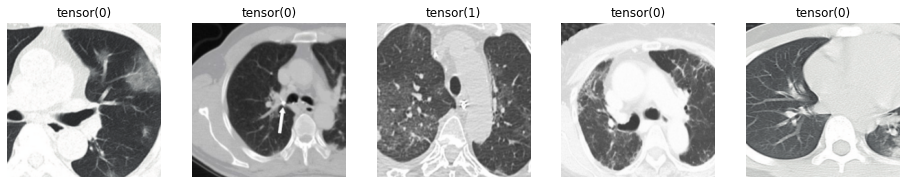

In [0]:
import matplotlib.pyplot as plt

## Method to display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax


# Displaying Images and other info about the test set
images, labels = next(iter(labeled_student_trainloader))
# print(" Image Size",images.size())
rand_idx = np.random.randint(len(images))
# print(labels[rand_idx])

fig, axes = plt.subplots(figsize=(16,5), ncols=5)
for ii in range(5):
    ax = axes[ii]
    # print(" Image Size",images[ii].size())
    ax.set_title(labels[ii])
    imshow(images[ii], ax=ax, normalize=True)

       

In [0]:
# Now we train the model
# We use the newly labeled trainloader for training and use the validloader data to evaluate the performance of our model

#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters() , lr=0.001)
# optimizer = optim.Adam(model.fc.parameters() , lr=0.001)

epochs = 50
#student_model = train(model, criterion, optimizer,labeled_student_trainloader,student_valid_loader)
# student_model = train(epochs, labeled_student_trainloader, student_valid_loader, model, optimizer, criterion, True)
student_model = train(epochs, labeled_student_trainloader, student_valid_loader, model, optimizer, criterion, True, save_path='./models/student.pth.tar', is_not_teacher=True)

# student_model = train(model, criterion, optimizer,student_trainloader, labeled_student_trainloader)



Epoch: 1 
	Train Loss: 0.159349 	Train Acc: 92.638037 
	Valid Loss: 1.172462 	Valid Acc: 50.000000
	Validation loss decreased (inf --> 1.172462).  Saving model ...
Epoch: 2 
	Train Loss: 0.125518 	Train Acc: 93.865031 
	Valid Loss: 3.057709 	Valid Acc: 47.500000
Epoch: 3 
	Train Loss: 0.112530 	Train Acc: 95.705521 
	Valid Loss: 2.811841 	Valid Acc: 47.500000
Epoch: 4 
	Train Loss: 0.074315 	Train Acc: 98.159509 
	Valid Loss: 4.257301 	Valid Acc: 45.000000
Epoch: 5 
	Train Loss: 0.063955 	Train Acc: 98.773006 
	Valid Loss: 3.203109 	Valid Acc: 50.000000
Epoch: 6 
	Train Loss: 0.053276 	Train Acc: 98.773006 
	Valid Loss: 4.385041 	Valid Acc: 52.500000
Epoch: 7 
	Train Loss: 0.029055 	Train Acc: 98.773006 
	Valid Loss: 2.543747 	Valid Acc: 55.000000
Epoch: 8 
	Train Loss: 0.015170 	Train Acc: 100.000000 
	Valid Loss: 2.422083 	Valid Acc: 42.500000
Epoch: 9 
	Train Loss: 0.008164 	Train Acc: 100.000000 
	Valid Loss: 2.358364 	Valid Acc: 45.000000
Epoch: 10 
	Train Loss: 0.004424 	Train Ac

# PATE
Shows us how much data has been leaked i.e the epsilon. 

Looks at the values produced from teachers and determines the level of agreement between them.



# TRAIN MNIST NORMALLY

In [0]:
# Normal DL Training
# normal_model = train(epochs, student_train_loader, student_valid_loader, model, optimizer, criterion, True)
normal_model = train(epochs, student_train_loader, student_valid_loader, model, optimizer, criterion, True, save_path='./models/normal.pth.tar', is_not_teacher=True)


Epoch: 1 
	Train Loss: 2.406557 	Train Acc: 56.441718 
	Valid Loss: 71.345871 	Valid Acc: 40.000000
	Validation loss decreased (inf --> 71.345871).  Saving model ...
Epoch: 2 
	Train Loss: 0.789787 	Train Acc: 65.030675 
	Valid Loss: 39.949337 	Valid Acc: 57.500000
	Validation loss decreased (71.345871 --> 39.949337).  Saving model ...
Epoch: 3 
	Train Loss: 0.595972 	Train Acc: 68.711656 
	Valid Loss: 2.211688 	Valid Acc: 45.000000
	Validation loss decreased (39.949337 --> 2.211688).  Saving model ...
Epoch: 4 
	Train Loss: 0.528409 	Train Acc: 78.527607 
	Valid Loss: 160.939697 	Valid Acc: 40.000000
Epoch: 5 
	Train Loss: 0.411557 	Train Acc: 80.368098 
	Valid Loss: 92.121185 	Valid Acc: 40.000000
Epoch: 6 
	Train Loss: 0.382044 	Train Acc: 82.208589 
	Valid Loss: 14.560678 	Valid Acc: 42.500000
Epoch: 7 
	Train Loss: 0.434697 	Train Acc: 78.527607 
	Valid Loss: 4.843095 	Valid Acc: 47.500000
Epoch: 8 
	Train Loss: 0.311494 	Train Acc: 87.116564 
	Valid Loss: 1.234060 	Valid Acc: 52.

### Comparing Normal DL Model and Privacy Preserving Model

In [0]:
# Test Dataset
batch_size=16
print(batch_size)
len(validset)
dataloader = DataLoader(validset, batch_size=batchsize, shuffle=False)


16


In [0]:
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def test(dataloader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(dataloader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the loss
        loss = criterion(output, target)
       
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('\tTest Loss: {:.6f}'.format(test_loss))
    print('\tTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function
print("Student Model")     
test(dataloader, student_model, criterion, True)

print("\n=======================\nNormal Model")
test(dataloader, normal_model, criterion, True)

Student Model
	Test Loss: 0.890114
	Test Accuracy: 76% (90/118)

Normal Model
	Test Loss: 0.745848
	Test Accuracy: 77% (92/118)
